v24_distilBERT_2の改良  
改良といっても同じモデルをスマートに分かりやすく定義したもの。  
性能は変わらない。  
しかし事前に定義してあるモデルであれば簡単にカスタムすることができることを示す。  
というかv24は分かりにくすぎる定義の仕方だから、これからはこのファイルで定義されているような方法でtransformersモデルを定義する。

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from transformers import DistilBertModel, DistilBertTokenizer, TrainingArguments, Trainer, DistilBertConfig
from transformers.modeling_outputs import SequenceClassifierOutput

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm


#import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


# distilBERTの定義  
実は下のようにかなり簡単に定義することができたのだ。  
定義済みのモデルを定義しているクラスを継承して、initのところで変更したい場所のみを再定義してあげるだけで良い。  
新しい層を増やしたりもしないならforwardもいじる必要がない。

In [20]:
#DistilBERT
from transformers import DistilBertForSequenceClassification, DistilBertConfig

class DistilBertModelCustom2(DistilBertForSequenceClassification):
    def __init__(self, config, num_sensor_dims=9):
        super().__init__(config)
        #センサデータ用のエンベディング層に変更　変更はここだけ
        self.distilbert.embeddings.word_embeddings = nn.Linear(num_sensor_dims, config.dim)

かなりスマート！

# データセットの用意

In [7]:
fold = "../../train_raw_npy/"
acc_xyz = np.load(f"{fold}acc_xyz_back80000.npy")
gyr_xyz = np.load(f"{fold}gyr_xyz_back80000.npy")
mag_xyz = np.load(f"{fold}mag_xyz_back80000.npy")
label = np.load(f"{fold}sampled_label_back80000.npy")
xyz = np.concatenate([acc_xyz, gyr_xyz, mag_xyz], axis=1)
del acc_xyz
del gyr_xyz
del mag_xyz
print(xyz.shape)
print(label.shape)

(79999, 9, 500)
(79999,)


In [11]:
from sklearn.preprocessing import StandardScaler

# データを2Dに変換して標準化
scaler = StandardScaler()
xyz_reshaped = xyz.transpose(0, 2, 1).reshape(-1, xyz.shape[1])  # (196072*500, 9)
scaled_xy = scaler.fit_transform(xyz_reshaped)  # 標準化
scaled_xy = scaled_xy.reshape(xyz.shape[0], xyz.shape[2], xyz.shape[1])  # 元の形に戻すが、(196072, 500, 9) の形状に
print(scaled_xy.shape)  # (196072, 500, 9)

(79999, 500, 9)


In [12]:
#おしり3万データを使う  
scaled_xyz = scaled_xy[-40000:-10000,:,:]
label_sm = label[-40000:-10000]
print(scaled_xyz.shape)
print(label_sm.shape)

(30000, 500, 9)
(30000,)


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz, label_sm, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())

Train data shape: (24000, 500, 9)
Test data shape: (6000, 500, 9)
Train label shape: (24000,)
Test label shape: (6000,)
1.0    4233
4.0    3919
7.0    3893
6.0    3585
2.0    3009
5.0    2965
8.0    1445
3.0     951
Name: count, dtype: int64
1.0    1043
7.0     964
4.0     958
6.0     922
5.0     773
2.0     721
8.0     373
3.0     246
Name: count, dtype: int64


In [16]:
# ラベルを0~7クラス分類とする
print(train_label)
train_label -=1
print(train_label)
print(test_label)
test_label -=1
print(test_label)

[4. 6. 4. ... 5. 5. 5.]
[3. 5. 3. ... 4. 4. 4.]
[7. 4. 3. ... 6. 6. 7.]
[6. 3. 2. ... 5. 5. 6.]


In [17]:
train_xyz = torch.from_numpy(train_xyz)
train_label = torch.from_numpy(train_label)
test_xyz = torch.from_numpy(test_xyz)
test_label = torch.from_numpy(test_label)

In [27]:
# データセットの準備

class SensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sensor_data = torch.tensor(self.data[idx], dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)

        attention_mask = torch.ones(sensor_data.shape[0], dtype=torch.long)  # (500,) の形状になるように

        return {
            "input_ids": sensor_data,
            "attention_mask": attention_mask,
            "labels": labels
        }

# データセットとデータローダの作成
train_dataset = SensorDataset(train_xyz, train_label)
eval_dataset = SensorDataset(test_xyz, test_label)

# モデルの用意と学習

In [28]:
config = DistilBertConfig(num_labels=8)
model = DistilBertModelCustom2(config, num_sensor_dims=9)
print(model)

DistilBertModelCustom2(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Linear(in_features=9, out_features=768, bias=True)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [29]:
# トレーニング設定
training_args = TrainingArguments(
    output_dir="./results_distilBERT",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    save_steps=0,
    save_total_limit=None,
    #logging_dir = "./logs_distilBERT",
    evaluation_strategy="steps",
    eval_steps=1_000,
    logging_steps=100,
    max_grad_norm=1.0, # 勾配クリッピング
    fp16=True, # fp16計算
    #weight_decay=0.01
)

# トレーナーの定義
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# トレーニングの実行
trainer.train()

  0%|          | 0/15000 [00:00<?, ?it/s]

C:\Users\kaiha\AppData\Local\Temp\ipykernel_41700\1253163707.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensor_data = torch.tensor(self.data[idx], dtype=torch.float)
C:\Users\kaiha\AppData\Local\Temp\ipykernel_41700\1253163707.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.labels[idx], dtype=torch.long)


{'loss': 1.537, 'grad_norm': 4.175840854644775, 'learning_rate': 4.966666666666667e-05, 'epoch': 0.07}
{'loss': 1.1515, 'grad_norm': 4.834768295288086, 'learning_rate': 4.933333333333334e-05, 'epoch': 0.13}
{'loss': 1.0553, 'grad_norm': 6.984920501708984, 'learning_rate': 4.9e-05, 'epoch': 0.2}
{'loss': 0.9636, 'grad_norm': 4.594533443450928, 'learning_rate': 4.866666666666667e-05, 'epoch': 0.27}
{'loss': 0.8604, 'grad_norm': 4.767513275146484, 'learning_rate': 4.8333333333333334e-05, 'epoch': 0.33}
{'loss': 0.8672, 'grad_norm': 3.163506507873535, 'learning_rate': 4.8e-05, 'epoch': 0.4}
{'loss': 0.8531, 'grad_norm': 4.664831638336182, 'learning_rate': 4.766666666666667e-05, 'epoch': 0.47}
{'loss': 0.794, 'grad_norm': 3.76281476020813, 'learning_rate': 4.7333333333333336e-05, 'epoch': 0.53}
{'loss': 0.7787, 'grad_norm': 5.490158557891846, 'learning_rate': 4.7e-05, 'epoch': 0.6}
{'loss': 0.7323, 'grad_norm': 5.858850955963135, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.67}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.7226790189743042, 'eval_runtime': 13.927, 'eval_samples_per_second': 430.818, 'eval_steps_per_second': 53.852, 'epoch': 0.67}
{'loss': 0.8261, 'grad_norm': 5.153783798217773, 'learning_rate': 4.633333333333333e-05, 'epoch': 0.73}
{'loss': 0.7332, 'grad_norm': 3.7768170833587646, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.8}
{'loss': 0.741, 'grad_norm': 4.150859832763672, 'learning_rate': 4.566666666666667e-05, 'epoch': 0.87}
{'loss': 0.707, 'grad_norm': 4.2421345710754395, 'learning_rate': 4.5333333333333335e-05, 'epoch': 0.93}
{'loss': 0.7093, 'grad_norm': 6.06294059753418, 'learning_rate': 4.5e-05, 'epoch': 1.0}
{'loss': 0.6376, 'grad_norm': 5.938371658325195, 'learning_rate': 4.466666666666667e-05, 'epoch': 1.07}
{'loss': 0.6324, 'grad_norm': 4.499295711517334, 'learning_rate': 4.433333333333334e-05, 'epoch': 1.13}
{'loss': 0.6069, 'grad_norm': 3.1949758529663086, 'learning_rate': 4.400333333333333e-05, 'epoch': 1.2}
{'loss': 0.6171, 'grad_norm': 2.8342335224

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.6406004428863525, 'eval_runtime': 13.6297, 'eval_samples_per_second': 440.214, 'eval_steps_per_second': 55.027, 'epoch': 1.33}
{'loss': 0.572, 'grad_norm': 5.068674087524414, 'learning_rate': 4.3003333333333336e-05, 'epoch': 1.4}
{'loss': 0.6555, 'grad_norm': 6.197843074798584, 'learning_rate': 4.267e-05, 'epoch': 1.47}
{'loss': 0.6113, 'grad_norm': 3.3605165481567383, 'learning_rate': 4.233666666666667e-05, 'epoch': 1.53}
{'loss': 0.5995, 'grad_norm': 5.400466442108154, 'learning_rate': 4.200333333333333e-05, 'epoch': 1.6}
{'loss': 0.597, 'grad_norm': 4.644441604614258, 'learning_rate': 4.1670000000000006e-05, 'epoch': 1.67}
{'loss': 0.5707, 'grad_norm': 4.362576961517334, 'learning_rate': 4.133666666666667e-05, 'epoch': 1.73}
{'loss': 0.545, 'grad_norm': 3.9429473876953125, 'learning_rate': 4.100333333333334e-05, 'epoch': 1.8}
{'loss': 0.5322, 'grad_norm': 5.184293746948242, 'learning_rate': 4.067e-05, 'epoch': 1.87}
{'loss': 0.555, 'grad_norm': 5.240501880645752, 'le

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.5582719445228577, 'eval_runtime': 13.7636, 'eval_samples_per_second': 435.934, 'eval_steps_per_second': 54.492, 'epoch': 2.0}
{'loss': 0.4944, 'grad_norm': 6.630228042602539, 'learning_rate': 3.9670000000000005e-05, 'epoch': 2.07}
{'loss': 0.512, 'grad_norm': 7.238468647003174, 'learning_rate': 3.9336666666666666e-05, 'epoch': 2.13}
{'loss': 0.4926, 'grad_norm': 4.350757122039795, 'learning_rate': 3.900333333333333e-05, 'epoch': 2.2}
{'loss': 0.4886, 'grad_norm': 4.381031036376953, 'learning_rate': 3.867e-05, 'epoch': 2.27}
{'loss': 0.4788, 'grad_norm': 5.7557477951049805, 'learning_rate': 3.833666666666667e-05, 'epoch': 2.33}
{'loss': 0.5017, 'grad_norm': 6.228657245635986, 'learning_rate': 3.8003333333333336e-05, 'epoch': 2.4}
{'loss': 0.4789, 'grad_norm': 6.686121940612793, 'learning_rate': 3.767e-05, 'epoch': 2.47}
{'loss': 0.4547, 'grad_norm': 3.9083399772644043, 'learning_rate': 3.733666666666667e-05, 'epoch': 2.53}
{'loss': 0.4393, 'grad_norm': 5.868422031402588,

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.49524882435798645, 'eval_runtime': 13.7357, 'eval_samples_per_second': 436.817, 'eval_steps_per_second': 54.602, 'epoch': 2.67}
{'loss': 0.4523, 'grad_norm': 3.0690689086914062, 'learning_rate': 3.633666666666667e-05, 'epoch': 2.73}
{'loss': 0.4135, 'grad_norm': 5.57290506362915, 'learning_rate': 3.6003333333333335e-05, 'epoch': 2.8}
{'loss': 0.4464, 'grad_norm': 4.782901763916016, 'learning_rate': 3.567e-05, 'epoch': 2.87}
{'loss': 0.438, 'grad_norm': 4.1000494956970215, 'learning_rate': 3.533666666666667e-05, 'epoch': 2.93}
{'loss': 0.4161, 'grad_norm': 6.046557426452637, 'learning_rate': 3.500333333333333e-05, 'epoch': 3.0}
{'loss': 0.3803, 'grad_norm': 7.50095272064209, 'learning_rate': 3.4670000000000005e-05, 'epoch': 3.07}
{'loss': 0.3791, 'grad_norm': 5.942519187927246, 'learning_rate': 3.4336666666666666e-05, 'epoch': 3.13}
{'loss': 0.4009, 'grad_norm': 4.941685676574707, 'learning_rate': 3.400333333333334e-05, 'epoch': 3.2}
{'loss': 0.4078, 'grad_norm': 4.87978

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4739724099636078, 'eval_runtime': 13.9923, 'eval_samples_per_second': 428.808, 'eval_steps_per_second': 53.601, 'epoch': 3.33}
{'loss': 0.3693, 'grad_norm': 4.648672580718994, 'learning_rate': 3.3003333333333336e-05, 'epoch': 3.4}
{'loss': 0.409, 'grad_norm': 6.3585076332092285, 'learning_rate': 3.267e-05, 'epoch': 3.47}
{'loss': 0.3615, 'grad_norm': 2.13918137550354, 'learning_rate': 3.233666666666667e-05, 'epoch': 3.53}
{'loss': 0.3288, 'grad_norm': 1.4804664850234985, 'learning_rate': 3.200333333333333e-05, 'epoch': 3.6}
{'loss': 0.3527, 'grad_norm': 10.818300247192383, 'learning_rate': 3.167e-05, 'epoch': 3.67}
{'loss': 0.3697, 'grad_norm': 2.9463558197021484, 'learning_rate': 3.133666666666667e-05, 'epoch': 3.73}
{'loss': 0.3484, 'grad_norm': 4.41594123840332, 'learning_rate': 3.1003333333333335e-05, 'epoch': 3.8}
{'loss': 0.3569, 'grad_norm': 8.39061450958252, 'learning_rate': 3.067333333333334e-05, 'epoch': 3.87}
{'loss': 0.3305, 'grad_norm': 4.584573745727539, '

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4022288918495178, 'eval_runtime': 13.899, 'eval_samples_per_second': 431.686, 'eval_steps_per_second': 53.961, 'epoch': 4.0}
{'loss': 0.3147, 'grad_norm': 4.937645435333252, 'learning_rate': 2.9673333333333336e-05, 'epoch': 4.07}
{'loss': 0.3117, 'grad_norm': 3.466356039047241, 'learning_rate': 2.934e-05, 'epoch': 4.13}
{'loss': 0.3084, 'grad_norm': 4.937248706817627, 'learning_rate': 2.9006666666666665e-05, 'epoch': 4.2}
{'loss': 0.296, 'grad_norm': 0.5385913252830505, 'learning_rate': 2.8673333333333336e-05, 'epoch': 4.27}
{'loss': 0.2731, 'grad_norm': 5.004635810852051, 'learning_rate': 2.834e-05, 'epoch': 4.33}
{'loss': 0.3222, 'grad_norm': 6.599077224731445, 'learning_rate': 2.800666666666667e-05, 'epoch': 4.4}
{'loss': 0.2925, 'grad_norm': 5.626999855041504, 'learning_rate': 2.7673333333333335e-05, 'epoch': 4.47}
{'loss': 0.2971, 'grad_norm': 5.845349311828613, 'learning_rate': 2.734e-05, 'epoch': 4.53}
{'loss': 0.2942, 'grad_norm': 6.776411533355713, 'learning_ra

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.41218507289886475, 'eval_runtime': 14.0038, 'eval_samples_per_second': 428.457, 'eval_steps_per_second': 53.557, 'epoch': 4.67}
{'loss': 0.3023, 'grad_norm': 3.9125354290008545, 'learning_rate': 2.6340000000000002e-05, 'epoch': 4.73}
{'loss': 0.2825, 'grad_norm': 2.9445271492004395, 'learning_rate': 2.600666666666667e-05, 'epoch': 4.8}
{'loss': 0.3016, 'grad_norm': 6.777063846588135, 'learning_rate': 2.5673333333333334e-05, 'epoch': 4.87}
{'loss': 0.2789, 'grad_norm': 5.468078136444092, 'learning_rate': 2.534e-05, 'epoch': 4.93}
{'loss': 0.2854, 'grad_norm': 0.4665370583534241, 'learning_rate': 2.5006666666666666e-05, 'epoch': 5.0}
{'loss': 0.2308, 'grad_norm': 0.1923653781414032, 'learning_rate': 2.4673333333333333e-05, 'epoch': 5.07}
{'loss': 0.2331, 'grad_norm': 1.5687986612319946, 'learning_rate': 2.434e-05, 'epoch': 5.13}
{'loss': 0.2172, 'grad_norm': 1.3474215269088745, 'learning_rate': 2.4010000000000002e-05, 'epoch': 5.2}
{'loss': 0.2325, 'grad_norm': 7.02117204

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4139785170555115, 'eval_runtime': 13.8809, 'eval_samples_per_second': 432.25, 'eval_steps_per_second': 54.031, 'epoch': 5.33}
{'loss': 0.215, 'grad_norm': 7.3068156242370605, 'learning_rate': 2.301e-05, 'epoch': 5.4}
{'loss': 0.244, 'grad_norm': 0.8516861796379089, 'learning_rate': 2.267666666666667e-05, 'epoch': 5.47}
{'loss': 0.2472, 'grad_norm': 4.215797424316406, 'learning_rate': 2.2343333333333337e-05, 'epoch': 5.53}
{'loss': 0.2099, 'grad_norm': 1.146868348121643, 'learning_rate': 2.201e-05, 'epoch': 5.6}
{'loss': 0.2638, 'grad_norm': 6.256469249725342, 'learning_rate': 2.167666666666667e-05, 'epoch': 5.67}
{'loss': 0.228, 'grad_norm': 8.38988971710205, 'learning_rate': 2.1343333333333336e-05, 'epoch': 5.73}
{'loss': 0.2204, 'grad_norm': 6.52501106262207, 'learning_rate': 2.101e-05, 'epoch': 5.8}
{'loss': 0.2086, 'grad_norm': 6.740945339202881, 'learning_rate': 2.0676666666666668e-05, 'epoch': 5.87}
{'loss': 0.2614, 'grad_norm': 5.5973052978515625, 'learning_rate'

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.36124512553215027, 'eval_runtime': 14.0071, 'eval_samples_per_second': 428.355, 'eval_steps_per_second': 53.544, 'epoch': 6.0}
{'loss': 0.1567, 'grad_norm': 3.156432867050171, 'learning_rate': 1.9676666666666667e-05, 'epoch': 6.07}
{'loss': 0.1788, 'grad_norm': 5.815388202667236, 'learning_rate': 1.9343333333333335e-05, 'epoch': 6.13}
{'loss': 0.1832, 'grad_norm': 5.580789566040039, 'learning_rate': 1.901e-05, 'epoch': 6.2}
{'loss': 0.1927, 'grad_norm': 4.808236598968506, 'learning_rate': 1.8676666666666667e-05, 'epoch': 6.27}
{'loss': 0.1942, 'grad_norm': 1.4715683460235596, 'learning_rate': 1.8343333333333334e-05, 'epoch': 6.33}
{'loss': 0.1808, 'grad_norm': 2.2665605545043945, 'learning_rate': 1.8010000000000002e-05, 'epoch': 6.4}
{'loss': 0.1613, 'grad_norm': 7.702442646026611, 'learning_rate': 1.7676666666666666e-05, 'epoch': 6.47}
{'loss': 0.1863, 'grad_norm': 1.409687876701355, 'learning_rate': 1.7343333333333334e-05, 'epoch': 6.53}
{'loss': 0.1657, 'grad_norm': 

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.37886112928390503, 'eval_runtime': 13.5441, 'eval_samples_per_second': 442.999, 'eval_steps_per_second': 55.375, 'epoch': 6.67}
{'loss': 0.1731, 'grad_norm': 5.71640682220459, 'learning_rate': 1.6346666666666667e-05, 'epoch': 6.73}
{'loss': 0.1604, 'grad_norm': 7.311762809753418, 'learning_rate': 1.601333333333333e-05, 'epoch': 6.8}
{'loss': 0.1962, 'grad_norm': 9.149402618408203, 'learning_rate': 1.568e-05, 'epoch': 6.87}
{'loss': 0.1937, 'grad_norm': 6.459594249725342, 'learning_rate': 1.5346666666666667e-05, 'epoch': 6.93}
{'loss': 0.1863, 'grad_norm': 1.6460694074630737, 'learning_rate': 1.5013333333333334e-05, 'epoch': 7.0}
{'loss': 0.1171, 'grad_norm': 7.2206315994262695, 'learning_rate': 1.4680000000000002e-05, 'epoch': 7.07}
{'loss': 0.1211, 'grad_norm': 1.14832603931427, 'learning_rate': 1.4346666666666666e-05, 'epoch': 7.13}
{'loss': 0.1205, 'grad_norm': 12.495306968688965, 'learning_rate': 1.4013333333333334e-05, 'epoch': 7.2}
{'loss': 0.1134, 'grad_norm': 4.

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.39659127593040466, 'eval_runtime': 13.6015, 'eval_samples_per_second': 441.129, 'eval_steps_per_second': 55.141, 'epoch': 7.33}
{'loss': 0.1338, 'grad_norm': 10.408910751342773, 'learning_rate': 1.3013333333333333e-05, 'epoch': 7.4}
{'loss': 0.1764, 'grad_norm': 3.2821264266967773, 'learning_rate': 1.268e-05, 'epoch': 7.47}
{'loss': 0.1381, 'grad_norm': 7.07549524307251, 'learning_rate': 1.2346666666666668e-05, 'epoch': 7.53}
{'loss': 0.1462, 'grad_norm': 3.8800928592681885, 'learning_rate': 1.2013333333333334e-05, 'epoch': 7.6}
{'loss': 0.1149, 'grad_norm': 3.9972879886627197, 'learning_rate': 1.168e-05, 'epoch': 7.67}
{'loss': 0.1069, 'grad_norm': 1.0943071842193604, 'learning_rate': 1.1346666666666666e-05, 'epoch': 7.73}
{'loss': 0.1643, 'grad_norm': 0.31997936964035034, 'learning_rate': 1.1013333333333333e-05, 'epoch': 7.8}
{'loss': 0.1394, 'grad_norm': 2.615537643432617, 'learning_rate': 1.0680000000000001e-05, 'epoch': 7.87}
{'loss': 0.1358, 'grad_norm': 7.4894123

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.35364773869514465, 'eval_runtime': 13.7002, 'eval_samples_per_second': 437.95, 'eval_steps_per_second': 54.744, 'epoch': 8.0}
{'loss': 0.1057, 'grad_norm': 4.4669694900512695, 'learning_rate': 9.683333333333333e-06, 'epoch': 8.07}
{'loss': 0.0604, 'grad_norm': 0.16228586435317993, 'learning_rate': 9.35e-06, 'epoch': 8.13}
{'loss': 0.0931, 'grad_norm': 0.6222922205924988, 'learning_rate': 9.016666666666668e-06, 'epoch': 8.2}
{'loss': 0.0871, 'grad_norm': 1.285581350326538, 'learning_rate': 8.683333333333334e-06, 'epoch': 8.27}
{'loss': 0.0782, 'grad_norm': 6.854059219360352, 'learning_rate': 8.350000000000001e-06, 'epoch': 8.33}
{'loss': 0.1001, 'grad_norm': 9.13924503326416, 'learning_rate': 8.016666666666667e-06, 'epoch': 8.4}
{'loss': 0.0896, 'grad_norm': 2.4884085655212402, 'learning_rate': 7.683333333333335e-06, 'epoch': 8.47}
{'loss': 0.1222, 'grad_norm': 4.626734256744385, 'learning_rate': 7.35e-06, 'epoch': 8.53}
{'loss': 0.1011, 'grad_norm': 0.9421495199203491, 

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.3641027808189392, 'eval_runtime': 13.6431, 'eval_samples_per_second': 439.783, 'eval_steps_per_second': 54.973, 'epoch': 8.67}
{'loss': 0.0852, 'grad_norm': 5.89087438583374, 'learning_rate': 6.35e-06, 'epoch': 8.73}
{'loss': 0.0671, 'grad_norm': 1.3322503566741943, 'learning_rate': 6.016666666666667e-06, 'epoch': 8.8}
{'loss': 0.0671, 'grad_norm': 11.377405166625977, 'learning_rate': 5.683333333333334e-06, 'epoch': 8.87}
{'loss': 0.1087, 'grad_norm': 6.972133159637451, 'learning_rate': 5.3500000000000004e-06, 'epoch': 8.93}
{'loss': 0.0911, 'grad_norm': 0.048824742436409, 'learning_rate': 5.016666666666666e-06, 'epoch': 9.0}
{'loss': 0.0803, 'grad_norm': 1.2831319570541382, 'learning_rate': 4.683333333333333e-06, 'epoch': 9.07}
{'loss': 0.0793, 'grad_norm': 7.384361267089844, 'learning_rate': 4.35e-06, 'epoch': 9.13}
{'loss': 0.0615, 'grad_norm': 3.8701367378234863, 'learning_rate': 4.0166666666666675e-06, 'epoch': 9.2}
{'loss': 0.0864, 'grad_norm': 0.23723290860652924

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.3667847514152527, 'eval_runtime': 13.5555, 'eval_samples_per_second': 442.623, 'eval_steps_per_second': 55.328, 'epoch': 9.33}
{'loss': 0.0594, 'grad_norm': 0.33493897318840027, 'learning_rate': 3.016666666666667e-06, 'epoch': 9.4}
{'loss': 0.0464, 'grad_norm': 9.130939483642578, 'learning_rate': 2.6833333333333336e-06, 'epoch': 9.47}
{'loss': 0.0556, 'grad_norm': 1.8955804109573364, 'learning_rate': 2.35e-06, 'epoch': 9.53}
{'loss': 0.0619, 'grad_norm': 4.983599662780762, 'learning_rate': 2.02e-06, 'epoch': 9.6}
{'loss': 0.0839, 'grad_norm': 0.11013741046190262, 'learning_rate': 1.6866666666666667e-06, 'epoch': 9.67}
{'loss': 0.0396, 'grad_norm': 0.07002782076597214, 'learning_rate': 1.3533333333333334e-06, 'epoch': 9.73}
{'loss': 0.0425, 'grad_norm': 0.8445449471473694, 'learning_rate': 1.0200000000000002e-06, 'epoch': 9.8}
{'loss': 0.0606, 'grad_norm': 0.022232308983802795, 'learning_rate': 6.866666666666667e-07, 'epoch': 9.87}
{'loss': 0.0618, 'grad_norm': 6.6086044

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.36046525835990906, 'eval_runtime': 13.6142, 'eval_samples_per_second': 440.716, 'eval_steps_per_second': 55.089, 'epoch': 10.0}
{'train_runtime': 2143.6751, 'train_samples_per_second': 111.957, 'train_steps_per_second': 6.997, 'train_loss': 0.33073791573842365, 'epoch': 10.0}


TrainOutput(global_step=15000, training_loss=0.33073791573842365, metrics={'train_runtime': 2143.6751, 'train_samples_per_second': 111.957, 'train_steps_per_second': 6.997, 'total_flos': 2.7950308416e+17, 'train_loss': 0.33073791573842365, 'epoch': 10.0})

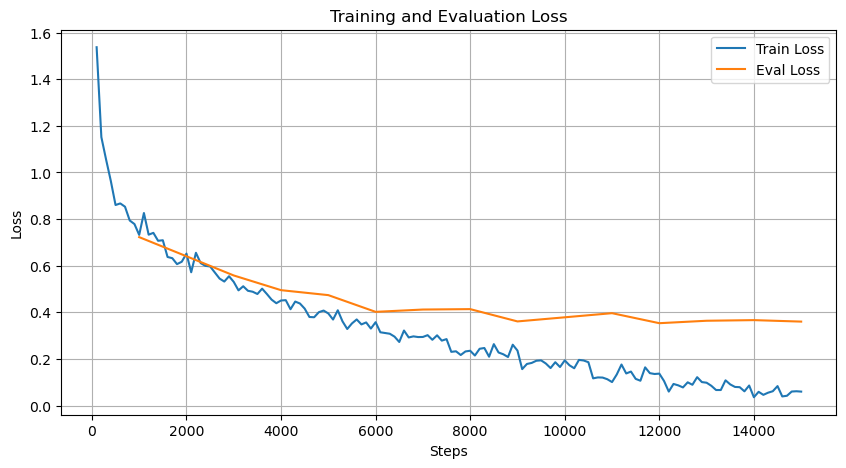

C:\Users\kaiha\AppData\Local\Temp\ipykernel_41700\1253163707.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensor_data = torch.tensor(self.data[idx], dtype=torch.float)
C:\Users\kaiha\AppData\Local\Temp\ipykernel_41700\1253163707.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.labels[idx], dtype=torch.long)


  0%|          | 0/750 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.89      0.92      0.91      1043
           2       0.95      0.93      0.94       721
           3       0.98      0.98      0.98       246
           4       0.97      0.97      0.97       958
           5       0.94      0.94      0.94       773
           6       0.91      0.91      0.91       922
           7       0.88      0.88      0.88       964
           8       0.85      0.83      0.84       373

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



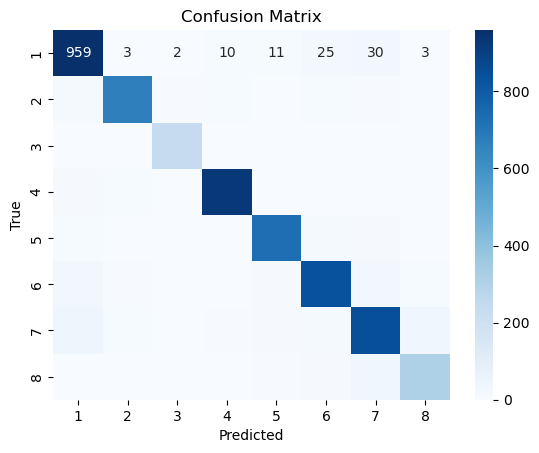

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

#final_evaluation = trainer.evaluate()

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# 最後の評価結果を追加
#eval_loss.append(final_evaluation["eval_loss"])
#eval_steps.append(trainer.state.global_step)

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
#true_labels = eval_dataset["labels"]
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1,9)], yticklabels=[str(i) for i in range(1,9)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [26]:
del model
del train_dataset
del trainer
del eval_dataset

import gc
gc.collect()
torch.cuda.empty_cache()

# ここから下は無視して構わない
下は保存用  
根本からtransformersアーキテクチャを変えるようなときは以下のように定義できる。これからカスタムするときは参考にすると良い

In [ ]:
class EmbeddingsCustom(nn.Module):
    def __init__(self,config,num_sensor_dims=9):
        super().__init__()
        self.sensor_embeddings = nn.Linear(num_sensor_dims, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.dim, eps=1e-12, elementwise_affine=True)
        self.dropout = nn.Dropout(p=0.1, inplace=False)
    
    def forward(self, input_ids=None, input_embeds=None):
        if input_ids is not None:
            input_embeds = self.sensor_embeddings(input_ids)  # (bs, max_seq_length, dim)

        seq_length = input_embeds.size(1)

        if hasattr(self, "position_ids"):
            position_ids = self.position_ids[:, :seq_length]
        else:
            position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)  # (max_seq_length)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)  # (bs, max_seq_length)

        position_embeddings = self.position_embeddings(position_ids)  # (bs, max_seq_length, dim)

        embeddings = input_embeds + position_embeddings  # (bs, max_seq_length, dim)
        embeddings = self.LayerNorm(embeddings)  # (bs, max_seq_length, dim)
        embeddings = self.dropout(embeddings)  # (bs, max_seq_length, dim)
        return embeddings
class DistilBertModelCustom(DistilBertModel):
    def __init__(self, config):
        super().__init__(config)
        # ここでembeddings層をガラッと変える。例えばforwardも変えるほどに変更するときなどは積極的に使うといいかも
        self.embeddings = EmbeddingsCustom(config)
        self.transformer = self.transformer

In [ ]:
config = DistilBertConfig()
model = DistilBertModel(config=config)
print(model)